In [1]:
import pandas as pd
import ramanchada2 as rc2
import os
import matplotlib.pyplot as plt

import numpy as np

# the constants

In [2]:
import ramanchada2.misc.constants  as rc2const

# https://physics.nist.gov/PhysRefData/Handbook/Tables/neontable2.htm

rc2const.neon_wl_532_nist_dict

print('question: Where are these values from?')

#ask Georgi - AFAIK they are from NIST site

question: Where are these values from?


In [3]:
# wavelength to cm-1:

ne_const_cm = (1/532 - 1/(np.array(list(rc2const.neon_wl_532_nist_dict.keys()))))*10**7

ne_const_cm

array([ 281.23305169,  821.08326266, 1119.89377896, 1312.99924528,
       1401.29666709, 1449.86099827, 1569.62548501, 1616.3243923 ,
       1710.80942882, 1770.4802298 , 1796.96834106, 1856.03990678,
       1866.90056507, 1976.53192224, 2034.36430846, 2061.5343444 ,
       2097.96233179, 2214.1817759 , 2334.78309582, 2394.42831892,
       2480.57025194, 2519.1232435 , 2573.29072291, 2622.14694358,
       2713.26982772, 2839.61263363, 2937.04448021, 2995.56491771,
       3011.30719367, 3131.48008943, 3178.57664889, 3428.53007914,
       3490.88235352, 3643.84721136, 3764.60572811, 3823.55863198,
       3910.07713556])

# the spectra

<Axes: >

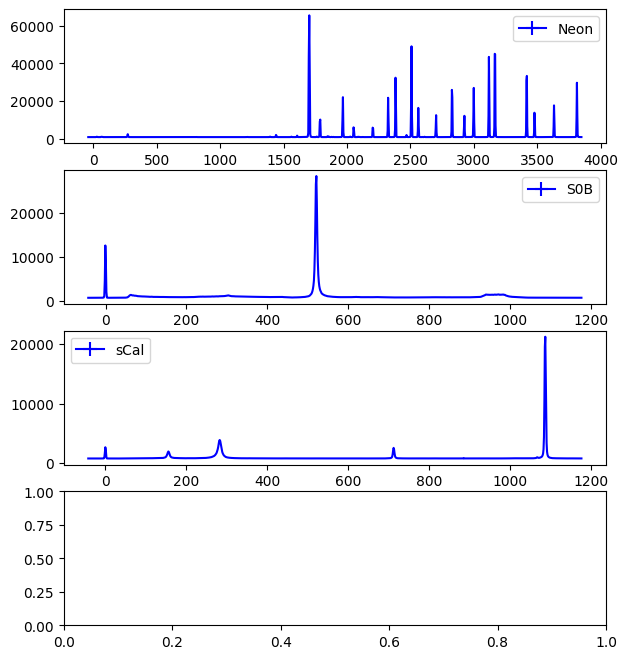

In [4]:
#folder = 'C:/Users/b_mab/saco SpeICat/PER-Nico/Si-Cal data/ICV_witec/'

neon_tag="Neon"
si_tag = "S0B"
pst_tag="PST"
cal_tag='sCal'

laser_wl = 532

file = 'Ne_WiICV532_600gmm_60ms.txt'
spe_neon = rc2.spectrum.from_local_file(os.path.join(folder,file))

file = 'S0B_WiICV532_Z100OP05_050_400msx10.txt'
spe_si = rc2.spectrum.from_local_file(os.path.join(folder,file))

file = 'sCAL09_WiICV532_Z100OP05_050_3000msx10.txt'
spe_cal = rc2.spectrum.from_local_file(os.path.join(folder,file))

#file = 'PST_WiICV532_Z100OP05_050_3000msx5.txt'
#spe_pst = rc2.spectrum.from_local_file(os.path.join(folder,file))

# Plot
fig, ax = plt.subplots(4, 1, figsize=(7,8))   
spe_neon.plot(label=neon_tag,color="blue",ax=ax[0])

#spe_neon = rc2.spectrum.Spectrum(x=spe_neon.x + 15, y=spe_neon.y)
#spe_neon.plot(ax=ax[0], label = 'shifted', color = 'red')

#ax[0].set_xlabel("cm-1")
spe_si.plot(label=si_tag,color="blue",ax=ax[1])

#spe_si = rc2.spectrum.Spectrum(x=spe_si.x + 15, y=spe_si.y)
#spe_si.plot(ax=ax[1], label = 'shifted', color = 'red')

#ax[1].set_xlabel("cm-1")
spe_cal.plot(label=cal_tag,color="blue",ax=ax[2])

#spe_cal = rc2.spectrum.Spectrum(x=spe_cal.x + 15, y=spe_cal.y)
#spe_cal.plot(ax=ax[2], label = 'shifted', color = 'red')

#spe_pst.plot(label=pst_tag,color="blue",ax=ax[3])


# Check calibration

In [5]:
import ramanchada2.misc.constants  as rc2const
noise_factor = 1.5
neon_wl = {
    785: rc2const.neon_wl_785_nist_dict,
    633: rc2const.neon_wl_633_nist_dict,
    532: rc2const.neon_wl_532_nist_dict
}

#####
# Derive calibration model

from ramanchada2.protocols.calibration import CalibrationModel

def calibration_model(laser_wl,spe_neon,spe_sil):
    calmodel = CalibrationModel(laser_wl)
    calmodel.prominence_coeff = 1
    # find_kw options affect how many peaks will be found
    find_kw = {"prominence" :spe_neon.y_noise * calmodel.prominence_coeff , "wlen" : 100, "width" :  1 }
    model_neon = calmodel.derive_model_curve(spe_neon,neon_wl[laser_wl],spe_units="cm-1",ref_units="nm",find_kw=find_kw,fit_peaks_kw={},should_fit = False,name="Neon calibration")
    spe_sil_ne_calib = model_neon.process(spe_sil,spe_units="cm-1",convert_back=False)
    find_kw = {"prominence" :spe_sil_ne_calib.y_noise * calmodel.prominence_coeff , "wlen" : 100, "width" :  1 }
    model_si = calmodel.derive_model_zero(spe_sil_ne_calib,ref={520.45:1},spe_units="nm",ref_units="cm-1",find_kw=find_kw,fit_peaks_kw={},should_fit=True,name="Si calibration")
# nico    model_si.peaks.to_csv(os.path.join(config_root,template_file.replace(".xlsx","peaks.csv")),index=False)

    spe_sil_calib = model_si.process(spe_sil_ne_calib,spe_units="nm",convert_back=False)

    #fig, ax =plt.subplots(1,1,figsize=(12,2))
    #spe_sil.plot(label="{} original".format(si_tag),ax=ax)
    #spe_sil_calib.plot(ax = ax,label="{} laser zeroed".format(si_tag),fmt=":")
    #ax.set_xlim(520.45-50,520.45+50)    
    #ax.set_xlabel("cm-1")
    
    return calmodel

<Axes: xlabel='nm'>

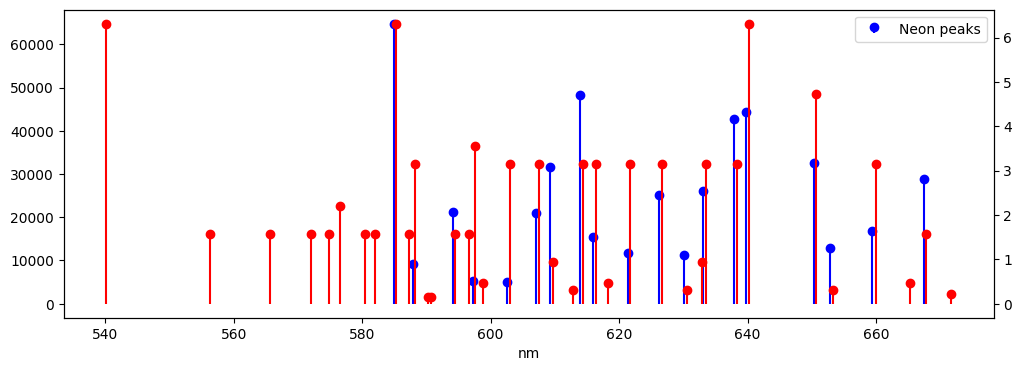

In [7]:
calmodel = calibration_model(laser_wl,spe_neon,spe_si)
calmodel.plot()

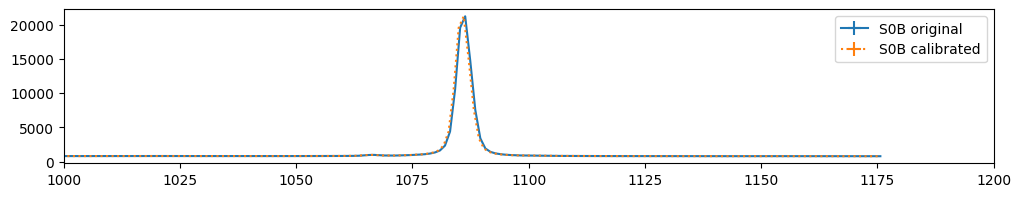

In [8]:

spe_cal_calib = calmodel.apply_calibration_x(spe_cal)

fig, ax =plt.subplots(1,1,figsize=(12,2))
spe_cal.plot(label="{} original".format(si_tag),ax=ax)
spe_cal_calib.plot(ax = ax,label="{} calibrated".format(si_tag),fmt=":")

plt.xlim(1000,1200)
#plt.xlim(100,300)
plt.show()

In [9]:
laser_wl

532

In [21]:
spe_sil = spe_si

calmodel = CalibrationModel(laser_wl)
calmodel.prominence_coeff = 1

# find_kw options affect how many peaks will be found
# prominence will be set 
find_kw = { "wlen" : 100, "width" :  1 }
model_neon = calmodel.derive_model_curve(spe_neon,neon_wl[laser_wl],spe_units="cm-1",ref_units="nm",find_kw=find_kw,fit_peaks_kw={},should_fit = True,name="Neon calibration")

####ne_const_cm_measured = (1/532 - 1/(model_neon.peaks.Wavelength))*10**7

fig, ax = plt.subplots(figsize=(15,4)) 
neon_processed = model_neon.process(spe_neon, spe_units="cm-1",convert_back=True)
neon_processed.plot(ax=ax, color = 'green', label = 'mode_neon.process')

#neon_processed.plot(color = 'red', ax=ax, label = 'model_neon.spe')
spe_neon.plot(ax=ax, label = 'original spectrum', linestyle = '--' )
####plt.vlines(ne_const_cm_measured, ymin=0,ymax=70000, color = 'purple', label = 'after model_neon.peaks.Wavelength')
plt.vlines(ne_const_cm, ymin=0,ymax=70000, color = 'gray', linestyle = '--', label='NIST')
#plt.xlim(1650,1800)

#plt.xlim(1650,2900)
#plt.xlim(2300,2600)

#plt.xlim(3000,3600)
plt.legend()

ValueError: ax should be a list or array of Axes when creating multiple subplots.

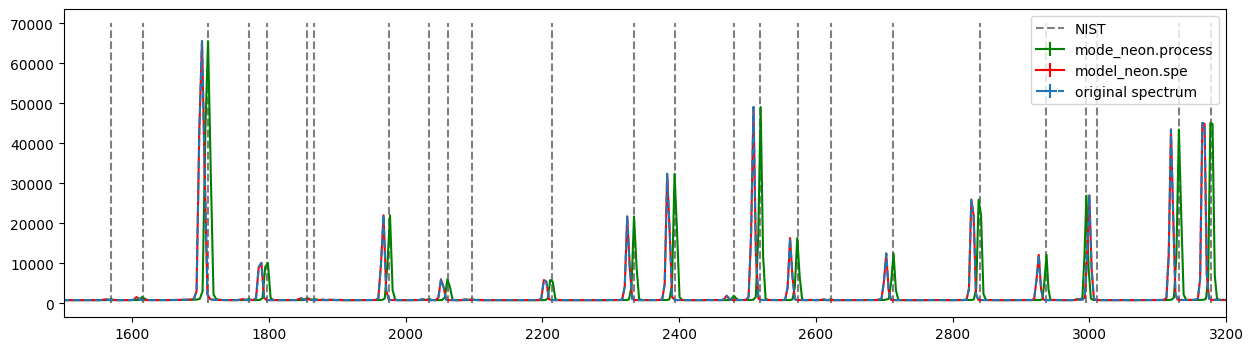

In [18]:
fig, ax = plt.subplots(figsize=(15,4)) 

model_neon.process(spe_neon, spe_units="cm-1",convert_back=True).plot(ax=ax, color = 'green', label = 'mode_neon.process')
model_neon.spe.plot(color = 'red', ax=ax, label = 'model_neon.spe')
spe_neon.plot(ax=ax, label = 'original spectrum', linestyle = '--' )

#plt.vlines(ne_const_cm_measured, ymin=0,ymax=70000, color = 'purple', label = 'after model_neon.peaks.Wavelength')
plt.vlines(ne_const_cm, ymin=0,ymax=70000, color = 'gray', linestyle = '--', label='NIST')
#plt.xlim(1650,1800)

plt.xlim(1650,2900)
plt.xlim(1500,3200)
#plt.xlim(2300,2600)

#plt.xlim(3000,3600)
plt.legend()

In [20]:
model_neon.matched_peaks

,Wavelength,Intensity,Source,Cluster
0,584.965471,1.000000e+00,spe,17
1,587.906096,6.835104e-02,spe,6
2,594.180507,1.696567e-01,spe,23
3,597.231705,0.000000e+00,spe,10
4,602.665996,7.368303e-03,spe,35
5,607.085138,1.696785e-01,spe,25
6,609.260283,3.184229e-01,spe,12
7,613.934935,4.789550e-01,spe,31
8,615.982241,1.118794e-01,spe,7
9,621.334825,6.872450e-02,spe,14


In [13]:
model_neon.peaks

,amplitude,amplitude_stderr,center,center_stderr,sigma,sigma_stderr,fwhm,fwhm_stderr,height,height_stderr
g00_p0,19979.297157,182.283889,584.965471,0.001272,0.119105,0.001223,0.280472,0.002880,66920.482503,605.961261
g00_p1,2530.764693,163.650038,587.906096,0.004978,0.080536,0.011881,0.189647,0.027977,12536.389439,1479.465588
g01_p0,4428.083597,16.873905,594.180507,0.000443,0.078054,0.000367,0.183803,0.000863,22632.396699,87.100239
g01_p1,1250.641669,17.654211,597.231705,0.001465,0.085070,0.001796,0.200324,0.004229,5865.009935,99.442086
g02_p0,1388.640076,9.034721,602.665996,0.000502,0.081817,0.001145,0.192664,0.002697,6771.052760,74.918711
g02_p1,4428.491151,8.420066,607.085138,0.000217,0.081446,0.000172,0.191791,0.000406,21691.802110,39.391940
g03_p0,10220.824972,41.328402,613.934935,0.000464,0.083912,0.000318,0.197597,0.000748,48592.980552,170.364889
g03_p1,3345.991940,41.479006,615.982241,0.001417,0.084498,0.001063,0.198978,0.002503,15797.455262,178.845748
g04_p0,2537.759219,13.100260,621.334825,0.000590,0.085367,0.000435,0.201023,0.001025,11859.639033,55.006617
g05_p0,6827.210708,12.318972,626.246701,0.000161,0.087278,0.000266,0.205525,0.000626,31206.654777,73.810185


In [14]:
model_neon.spe_pos_dict

{np.float64(584.9654708885548): np.float64(19979.29715703588),
 np.float64(587.9060960014639): np.float64(2530.764692622709),
 np.float64(594.180507172662): np.float64(4428.083596888973),
 np.float64(597.2317051224709): np.float64(1250.641669494997),
 np.float64(602.6659964631717): np.float64(1388.6400762348615),
 np.float64(607.0851376782687): np.float64(4428.49115144502),
 np.float64(609.2602832867299): np.float64(7214.27532290361),
 np.float64(613.9349352901752): np.float64(10220.824972247096),
 np.float64(615.9822413964445): np.float64(3345.991939916729),
 np.float64(621.3348250589811): np.float64(2537.7592185539497),
 np.float64(626.246700551304): np.float64(6827.210708080425),
 np.float64(630.064513185747): np.float64(2595.8441936880854),
 np.float64(633.0223079076368): np.float64(6080.8252865615705),
 np.float64(637.8721213091393): np.float64(10247.793524349965),
 np.float64(639.791837235907): np.float64(13382.501772035303),
 np.float64(650.2101579639784): np.float64(9568.070663

In [16]:
model_neon.matched_peaks 

,Wavelength,Intensity,Source,Cluster
0,584.965471,1.000000e+00,spe,27
1,587.906096,6.835104e-02,spe,35
2,594.180507,1.696567e-01,spe,20
3,597.231705,0.000000e+00,spe,0
4,602.665996,7.368303e-03,spe,15
5,607.085138,1.696785e-01,spe,11
6,609.260283,3.184229e-01,spe,24
7,613.934935,4.789550e-01,spe,4
8,615.982241,1.118794e-01,spe,21
9,621.334825,6.872450e-02,spe,34
